# 1. Data Preparation
Load and combine all csv-files from different experiments, add Meta Information:
- setup: docker/native
- side: client/server
- experiment: experiment_XX

In [22]:
import pandas as pd
import glob
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
files = glob.glob('../data/macbook/*/experiment_*/*/*.csv')

In [32]:
def parse_meta_from_path(path):
    parts = Path(path).parts
    setup = parts[-4]              # z. B. 'docker' oder 'native'
    experiment = parts[-3]         # z. B. 'experiment_01'
    side = 'client' if 'client' in parts[-1] else 'server'
    return setup, experiment, side

In [33]:
df_all = pd.concat([
    pd.read_csv(f).assign(
        setup=parse_meta_from_path(f)[0],
        experiment=parse_meta_from_path(f)[1],
        side=parse_meta_from_path(f)[2]
    )
    for f in files
]).reset_index(drop=True)

In [34]:
df_all = df_all[df_all['run'] != 1].reset_index(drop=True)

In [36]:
df_experiment_01 = df_all[df_all['experiment'] == "experiment_01"].reset_index(drop=True).copy()

In [41]:
metrics = ['duration_sec', 'cpu_percent', 'ram_percent']

# 2. Measurement Perspective
Investigate differences between client & server measurements:
- handshake duration
- CPU/RAM usage

In [51]:
def plot_box_by_side_per_setup(df, metric, ylabel, yscale_log=False, show_fliers=True):
    for setup in df['setup'].unique():
        plt.figure(figsize=(6, 4))
        subset = df[df['setup'] == setup]
        sns.boxplot(data=subset, x='side', y=metric, showfliers=show_fliers)
        plt.title(f'{metric.replace("_", " ").title()} by Side ({setup.capitalize()})')
        plt.ylabel(ylabel)
        plt.xlabel('')
        if yscale_log:
            plt.yscale('log')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

def plot_mean_by_side_per_setup(df, metric, ylabel):
    for setup in df['setup'].unique():
        plt.figure(figsize=(6, 4))
        subset = df[df['setup'] == setup]
        means = subset.groupby('side')[metric].mean()
        sns.barplot(x=means.index, y=means.values, palette=['steelblue', 'darkorange'])
        plt.title(f'Mean {metric.replace("_", " ").title()} by Side ({setup.capitalize()})')
        plt.ylabel(ylabel)
        plt.xlabel('')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

Duration


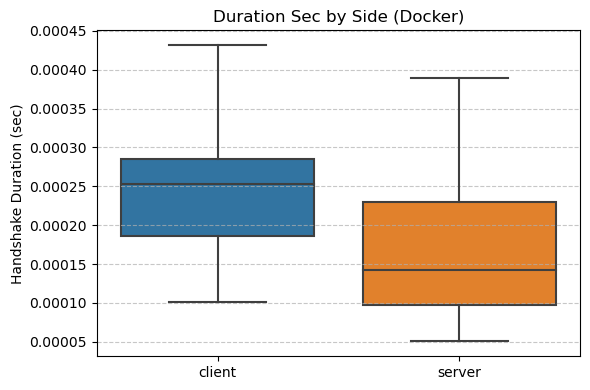

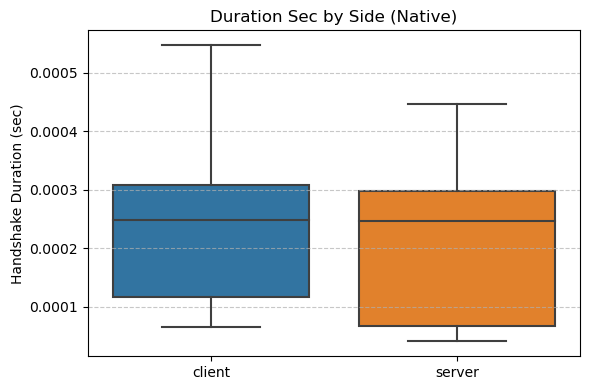

CPU


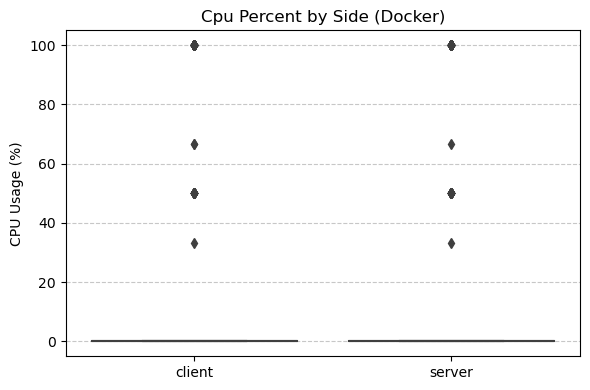

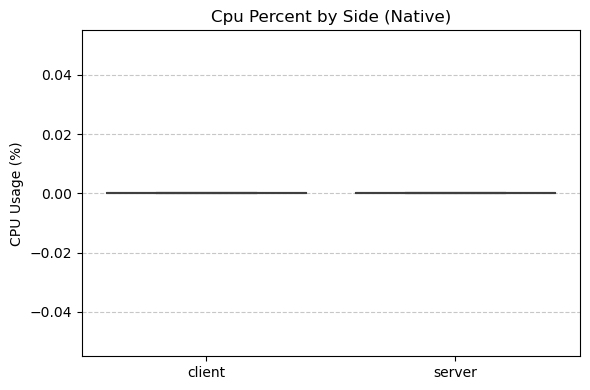

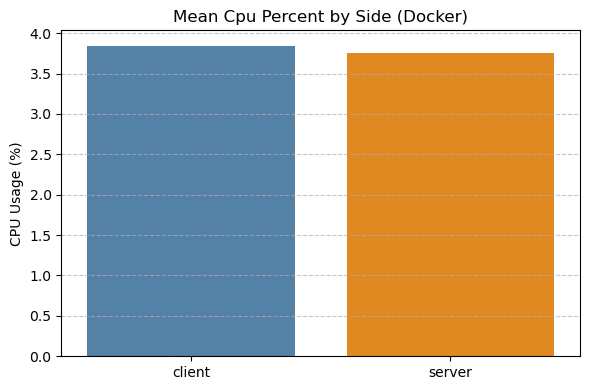

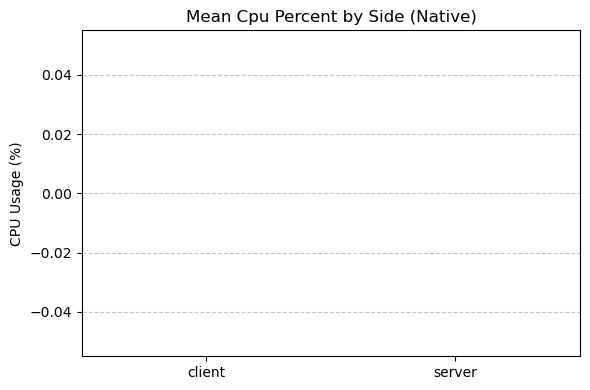

RAM


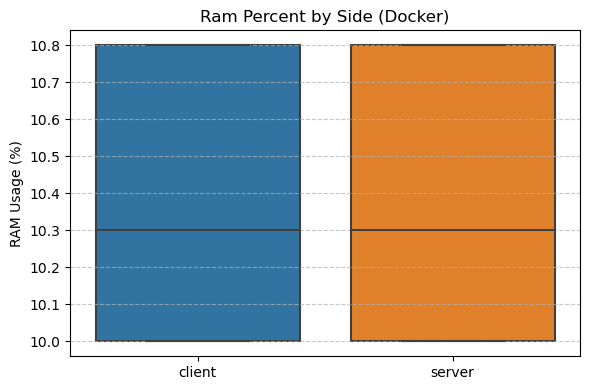

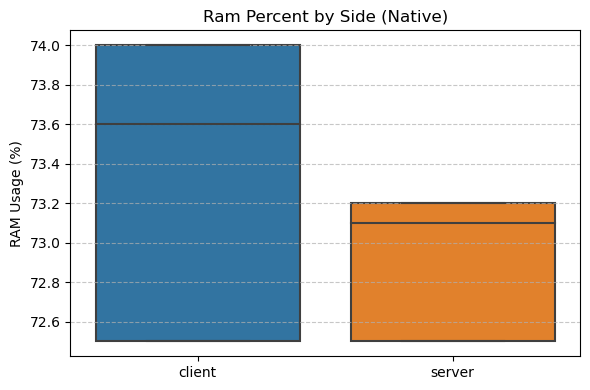

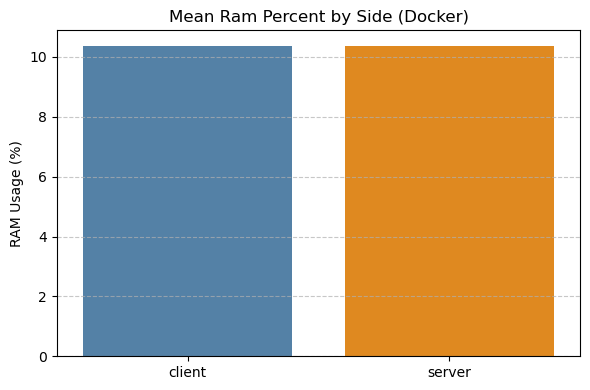

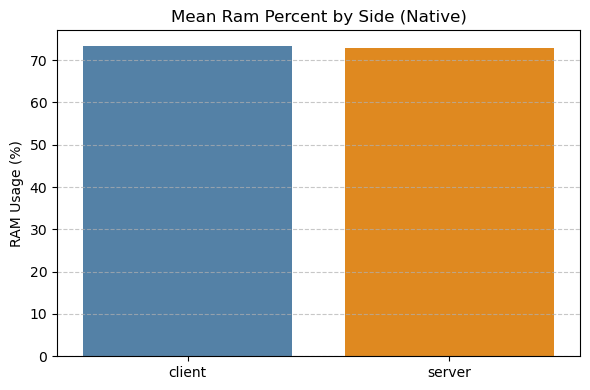

In [96]:
print("Duration")
plot_box_by_side_per_setup(df_experiment_01, 'duration_sec', 'Handshake Duration (sec)', show_fliers=False)
print("CPU")
plot_box_by_side_per_setup(df_experiment_01, 'cpu_percent', 'CPU Usage (%)', show_fliers=True)
plot_mean_by_side_per_setup(df_experiment_01, 'cpu_percent', 'CPU Usage (%)')
print("RAM")
plot_box_by_side_per_setup(df_experiment_01, 'ram_percent', 'RAM Usage (%)', show_fliers=True)
plot_mean_by_side_per_setup(df_experiment_01, 'ram_percent', 'RAM Usage (%)')

# 3. Execution Environment
Compare measurement results between docker- and native-setup.

In [77]:
def plot_box_by_setup_per_side(df, metric, ylabel, show_fliers=True):
    for side in df['side'].unique():
        subset = df[df['side'] == side]
        plt.figure(figsize=(6, 4))
        sns.boxplot(data=subset, x='setup', y=metric, showfliers=show_fliers)
        plt.title(f'{metric.replace("_", " ").title()} by Setup ({side.capitalize()})')
        plt.ylabel(ylabel)
        plt.xlabel('')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    
def plot_mean_by_setup_per_side(df, metric, ylabel):
    for side in df['side'].unique():
        subset = df[df['side'] == side]
        means = subset.groupby('setup')[metric].mean()
        
        plt.figure(figsize=(6, 4))
        sns.barplot(x=means.index, y=means.values, palette='muted')
        plt.title(f'Mean {metric.replace("_", " ").title()} by Setup ({side.capitalize()})')
        plt.ylabel(ylabel)
        #plt.yscale('log')
        plt.xlabel('')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

Duration


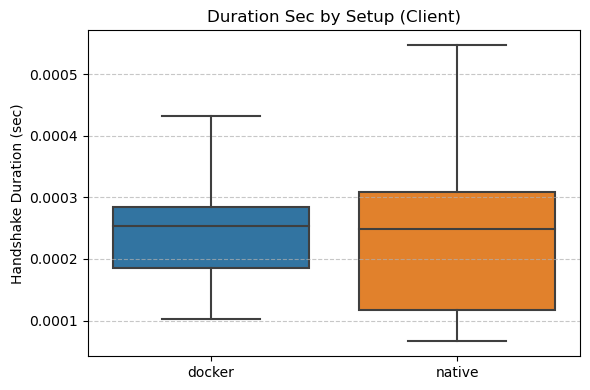

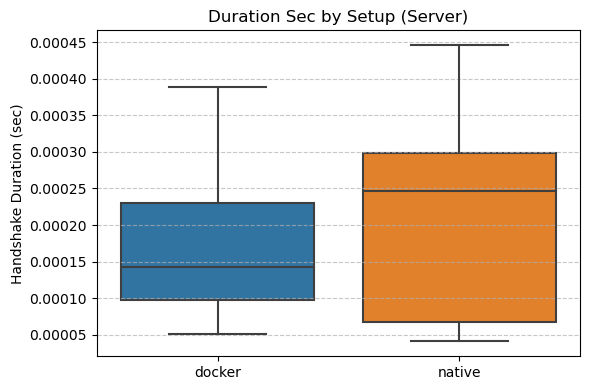

CPU


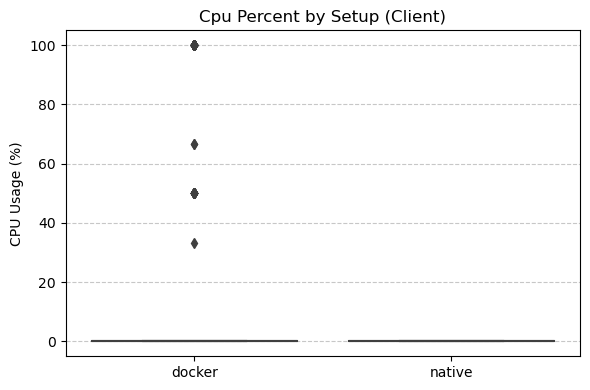

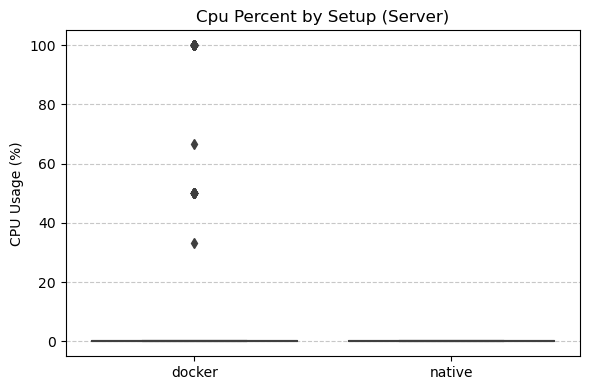

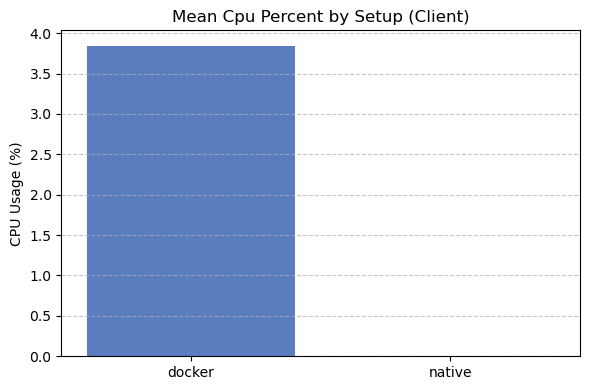

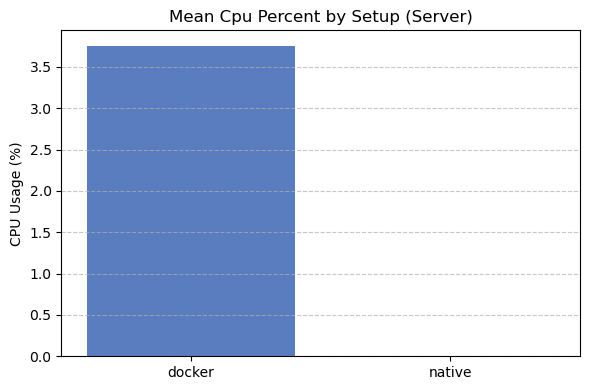

RAM


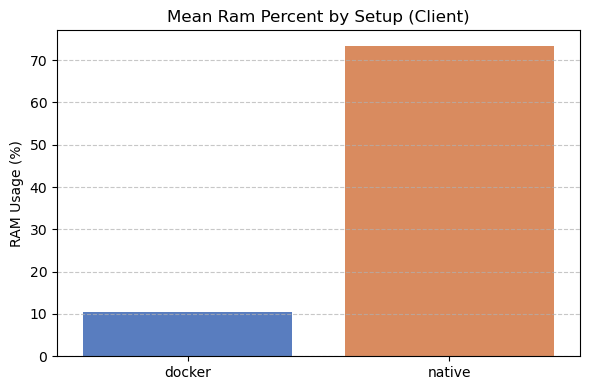

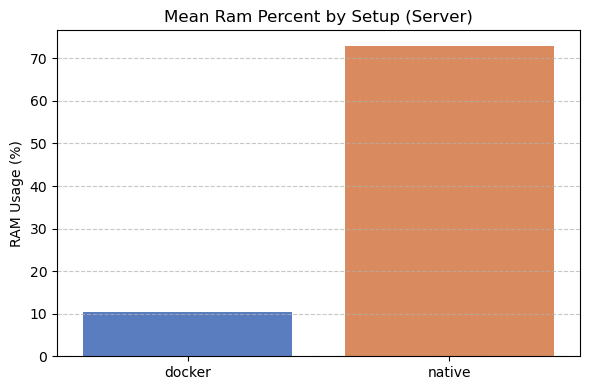

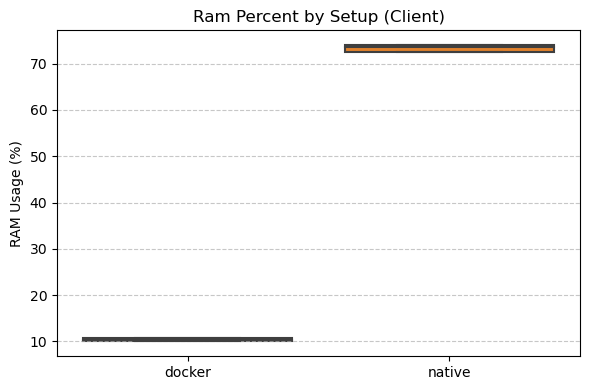

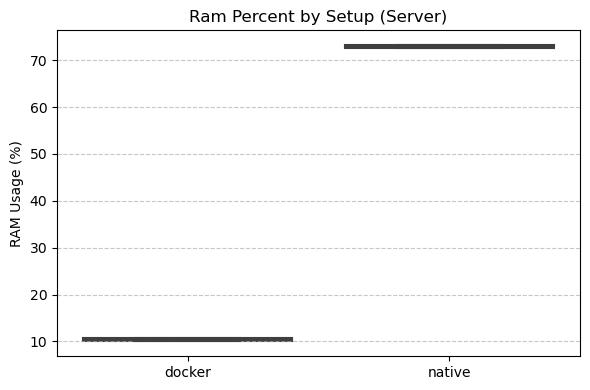

In [100]:
print("Duration")
plot_box_by_setup_per_side(df_experiment_01, 'duration_sec', 'Handshake Duration (sec)', show_fliers=False)
print("CPU")
plot_box_by_setup_per_side(df_experiment_01, 'cpu_percent', 'CPU Usage (%)')
plot_mean_by_setup_per_side(df_experiment_01, 'cpu_percent', 'CPU Usage (%)')
print("RAM")
plot_mean_by_setup_per_side(df_experiment_01, 'ram_percent', 'RAM Usage (%)')
plot_box_by_setup_per_side(df_experiment_01, 'ram_percent', 'RAM Usage (%)')

# 4. Generate Paramters for Latex Plots

In [93]:
import numpy as np

def generate_tikz_addplot(df, metric, group_col='setup', colors=None):
    """
    Erzeugt TikZ \addplot-Blöcke für einen Boxplot-Vergleich anhand einer Metrik.
    
    Parameter:
        df: DataFrame mit den Messwerten
        metric: Spaltenname der Metrik (z. B. 'duration_sec')
        group_col: Gruppierung ('setup' für Docker vs Native oder 'side' für Client vs Server)
        colors: optionales dict für Farbzuweisung, z. B. {'client': 'blue!20', 'server': 'orange!20'}
    """
    stats = {}
    groups = sorted(df[group_col].unique())
    
    for i, group in enumerate(groups, start=1):
        values = df[df[group_col] == group][metric].dropna()
        if len(values) == 0:
            continue
        q1 = np.percentile(values, 25)
        q3 = np.percentile(values, 75)
        iqr = q3 - q1
        lower_whisker = values[values >= q1 - 1.5 * iqr].min()
        upper_whisker = values[values <= q3 + 1.5 * iqr].max()
        median = np.median(values)
        outliers = values[(values < lower_whisker) | (values > upper_whisker)].tolist()
        
        fill_color = colors[group] if colors and group in colors else 'gray!20'

        print(f"% {group} ({metric})")
        print("\\addplot+[")
        print("  boxplot prepared={")
        print(f"    lower whisker={lower_whisker:.6f},")
        print(f"    lower quartile={q1:.6f},")
        print(f"    median={median:.6f},")
        print(f"    upper quartile={q3:.6f},")
        print(f"    upper whisker={upper_whisker:.6f}")
        print("  },")
        print(f"  fill={fill_color}")
        print("] coordinates {")
        for out in outliers:
            print(f"({i},{out:.6f})")
        print("};\n")

In [105]:
generate_tikz_addplot(df_experiment_01[df_experiment_01["side"] == "client"], metric='ram_percent', group_col='setup',
                      colors={'docker': 'blue!20', 'native': 'orange!20'})

% docker (ram_percent)
\addplot+[
  boxplot prepared={
    lower whisker=10.000000,
    lower quartile=10.000000,
    median=10.300000,
    upper quartile=10.800000,
    upper whisker=10.800000
  },
  fill=blue!20
] coordinates {
};

% native (ram_percent)
\addplot+[
  boxplot prepared={
    lower whisker=72.500000,
    lower quartile=72.500000,
    median=73.600000,
    upper quartile=74.000000,
    upper whisker=74.000000
  },
  fill=orange!20
] coordinates {
};



# 5. Plot for KEX Modes

In [106]:
def plot_box_by_mode(df, metric, ylabel=None, yscale_log=False, showfliers=True, title=None):
    """
    Erzeugt einen Boxplot für eine bestimmte Metrik gruppiert nach 'mode' (classic, pqc, hybrid).
    
    Parameter:
        df         : DataFrame mit mindestens 'mode' und der gewünschten Metrik
        metric     : Name der Metrik-Spalte (z. B. 'duration_sec')
        ylabel     : Y-Achsenbeschriftung (optional, Standard = Metrikname)
        yscale_log : True → logarithmische Y-Achse
        showfliers : True → Ausreißer anzeigen
        title      : Plot-Titel (optional)
    """
    plt.figure(figsize=(6, 4))
    palette = {'classic': 'blue', 'pqc': 'red', 'hybrid': 'brown'}

    sns.boxplot(
        data=df,
        x='mode',
        y=metric,
        palette=palette,
        showfliers=showfliers
    )

    if yscale_log:
        plt.yscale('log')

    plt.title(title or f'{metric.replace("_", " ").title()} by Mode')
    plt.ylabel(ylabel or metric.replace('_', ' ').title())
    plt.xlabel('Key Exchange Mode')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

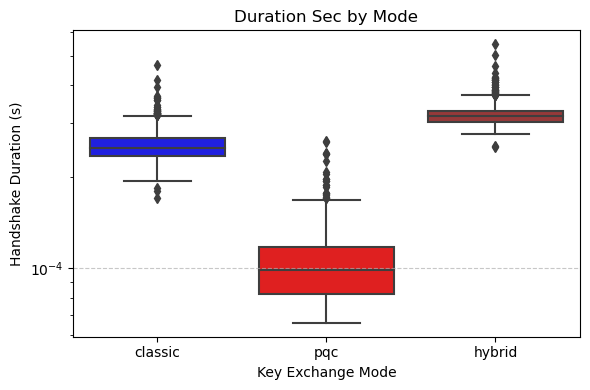

In [113]:
plot_box_by_mode(df_experiment_01[(df_experiment_01["side"] == "client") & (df_experiment_01["setup"] == "native")], metric='duration_sec', ylabel='Handshake Duration (s)', yscale_log=True)

In [115]:
generate_tikz_addplot(df_experiment_01[(df_experiment_01["side"] == "client") & (df_experiment_01["setup"] == "native")], metric='duration_sec', group_col='mode',
                      colors={'docker': 'blue!20', 'native': 'orange!20'})

% classic (duration_sec)
\addplot+[
  boxplot prepared={
    lower whisker=0.000194,
    lower quartile=0.000234,
    median=0.000249,
    upper quartile=0.000268,
    upper whisker=0.000318
  },
  fill=gray!20
] coordinates {
(1,0.000358)
(1,0.000324)
(1,0.000325)
(1,0.000368)
(1,0.000394)
(1,0.000324)
(1,0.000327)
(1,0.000320)
(1,0.000340)
(1,0.000323)
(1,0.000319)
(1,0.000320)
(1,0.000322)
(1,0.000320)
(1,0.000335)
(1,0.000358)
(1,0.000321)
(1,0.000322)
(1,0.000329)
(1,0.000322)
(1,0.000363)
(1,0.000179)
(1,0.000346)
(1,0.000363)
(1,0.000170)
(1,0.000331)
(1,0.000340)
(1,0.000418)
(1,0.000330)
(1,0.000325)
(1,0.000183)
(1,0.000367)
(1,0.000335)
(1,0.000330)
(1,0.000467)
(1,0.000331)
(1,0.000325)
};

% hybrid (duration_sec)
\addplot+[
  boxplot prepared={
    lower whisker=0.000277,
    lower quartile=0.000303,
    median=0.000317,
    upper quartile=0.000331,
    upper whisker=0.000371
  },
  fill=gray!20
] coordinates {
(2,0.000441)
(2,0.000416)
(2,0.000384)
(2,0.000372)
(2,0.00042

In [116]:
df_all

,run,mode,duration_sec,shared_secret_length,cpu_percent,ram_percent,success,error,netem,setup,experiment,side
0,2,classic,0.000276,32,0.0,7.6,1,NaN,netem_package_loss,docker,experiment_04_package_loss,client
1,3,classic,0.000491,32,0.0,7.6,1,NaN,netem_package_loss,docker,experiment_04_package_loss,client
2,4,classic,0.000226,32,0.0,7.6,1,NaN,netem_package_loss,docker,experiment_04_package_loss,client
3,5,classic,0.000236,32,0.0,7.6,1,NaN,netem_package_loss,docker,experiment_04_package_loss,client
4,6,classic,0.000193,32,0.0,7.6,1,NaN,netem_package_loss,docker,experiment_04_package_loss,client
...,...,...,...,...,...,...,...,...,...,...,...,...
77917,996,hybrid,0.000275,32,0.0,72.5,1,NaN,NaN,native,experiment_01,server
77918,997,hybrid,0.000273,32,0.0,72.5,1,NaN,NaN,native,experiment_01,server
77919,998,hybrid,0.000274,32,0.0,72.5,1,NaN,NaN,native,experiment_01,server
77920,999,hybrid,0.000286,32,0.0,72.5,1,NaN,NaN,native,experiment_01,server


# 6. Plot Network Profiles

In [139]:
def plot_box_and_strip_by_netem_mode(df, metric, profile_order=None, logscale=True):
    """
    Erstellt einen kombinierten Boxplot + Stripplot zur Darstellung der Verteilung 
    einer Metrik (z.B. duration_sec) nach Netzwerkprofil (netem) und KEX-Modus.

    Parameter:
        df             : DataFrame mit mind. 'netem', 'mode' und Metrikspalte
        metric         : Spaltenname der zu analysierenden Metrik
        profile_order  : Manuelle Reihenfolge der Netem-Profile (Liste von Strings)
        logscale       : True → Y-Achse logarithmisch
    """
    plt.figure(figsize=(12, 6))

    # Boxplot
    sns.boxplot(
        data=df,
        x="netem",
        y=metric,
        hue="mode",
        order=profile_order,
        hue_order=["classic", "pqc", "hybrid"],
        palette="muted",
        showcaps=True,
        boxprops={"facecolor": "lightgray", "alpha": 0.4},
        showfliers=False,
        whiskerprops={"linewidth": 1}
    )

    # Stripplot (Einzeldatenpunkte)
    sns.stripplot(
        data=df,
        x="netem",
        y=metric,
        hue="mode",
        dodge=True,
        order=profile_order,
        hue_order=["classic", "pqc", "hybrid"],
        palette="muted",
        jitter=0.2,
        size=3,
        alpha=0.7
    )

    if logscale:
        plt.yscale("log")

    plt.title(f"{metric.replace('_', ' ').title()} Distribution across Network Profiles (log scale)" if logscale else f"{metric.replace('_', ' ').title()} Distribution")
    plt.ylabel(f"{metric.replace('_', ' ').title()} (log scale)" if logscale else metric.replace('_', ' ').title())
    plt.xlabel("Network Profile")
    plt.xticks(rotation=15)
    plt.grid(axis="y", which="both", linestyle="--", linewidth=0.5)

    # Doppelte Legenden filtern
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:3], labels[:3], title="Mode", loc="upper left")

    plt.tight_layout()
    plt.savefig("../plots/netem_kexmode_boxplot.pdf")
    plt.show()
   

In [129]:
plot_box_and_strip_by_netem_mode(
    df=df_all[df_all["setup"]=="docker"],
    metric='duration_sec',
    ylabel='Handshake Duration (s)',
    yscale_log=True,
    showfliers=False
)


TypeError: plot_box_and_strip_by_netem_mode() got an unexpected keyword argument 'ylabel'

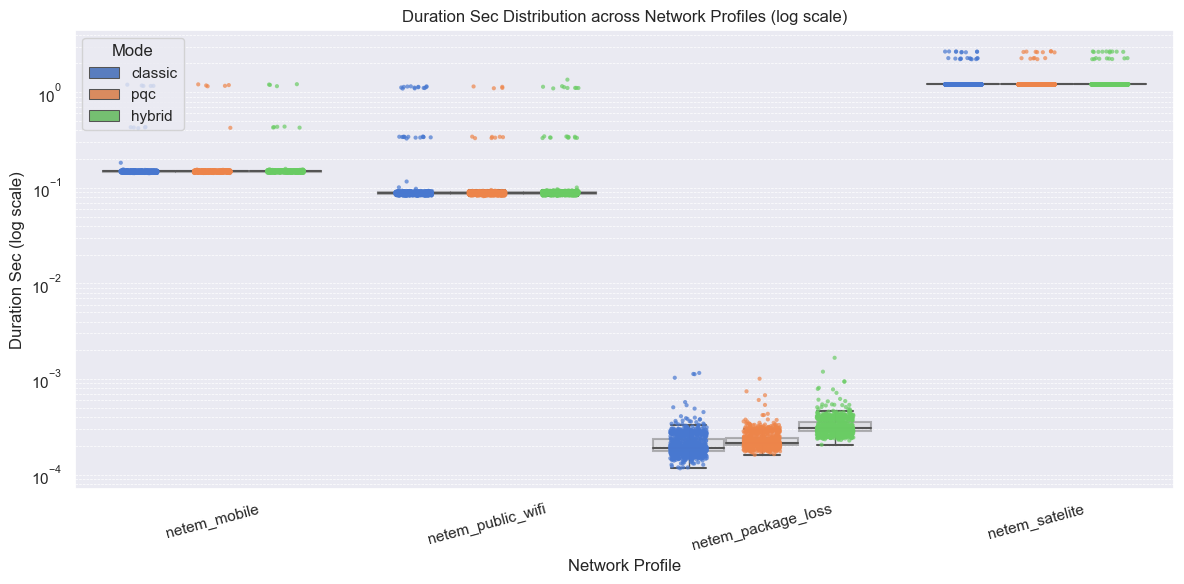

In [140]:
profile_order = ["netem_mobile", "netem_public_wifi", "netem_package_loss", "netem_satelite"]

plot_box_and_strip_by_netem_mode(
    df=df_all[(df_all["setup"]=="docker") & (df_all["side"] == "client")],
    metric="duration_sec",
    profile_order=profile_order,
    logscale=True
)
